In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pathlib
import random
import cv2

import matplotlib.pyplot as plt


### adding some images to shine to balance out dataset

caution --> do not  run this section

In [2]:
img_height = 200
img_width = 200

In [3]:
SHINE_DIR = pathlib.Path('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine')
SHINE_DIR

PosixPath('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine')

In [4]:
shine_sample = random.sample(list(SHINE_DIR.glob('*')), 50)
shine_sample[:3]

[PosixPath('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine/shine232.jpg'),
 PosixPath('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine/shine128.jpg'),
 PosixPath('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine/shine12.jpg')]

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  # tf.keras.layers.RandomContrast(factor=0.5),
  tf.keras.layers.RandomCrop(img_height, img_width),
  tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='reflect', interpolation='bilinear')
])

In [6]:
def add_aug_img(samples):
  for sample in samples:
    sample = str(sample)
    img = cv2.imread(sample)
    # img = img[...,::-1]
    img = tf.cast(tf.expand_dims(img, 0), tf.float32)
    augmented_image = data_augmentation(img)
    img = augmented_image[0].numpy().astype("uint8")
    fname = 'aug_'+sample.split('/')[-1]
    filepath = pathlib.PurePath(SHINE_DIR, fname)
    cv2.imwrite(str(filepath), img)

In [ ]:
## add_aug_img(shine_sample) ##do not run this cell specifically

##### getting it :)

In [ ]:
sample = shine_sample[0]
sample = str(sample)
fname = 'aug_'+sample.split('/')[-1]
fname

'aug_shine99.jpg'

In [ ]:
print(shine_sample[0])

/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine/shine99.jpg


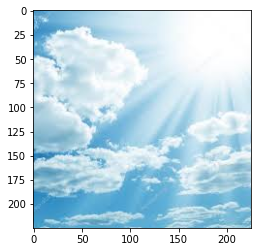

In [ ]:
img = cv2.imread(str(shine_sample[7]))

img = img[...,::-1]

plt.imshow(img)

In [ ]:
img = tf.cast(tf.expand_dims(img, 0), tf.float32)
type(img), img.numpy().shape

(tensorflow.python.framework.ops.EagerTensor, (1, 225, 225, 3))

In [ ]:
augmented_image = data_augmentation(img)
x = augmented_image[0].numpy().astype("uint8")
type(x)

numpy.ndarray

In [ ]:
filepath = pathlib.PurePath(SHINE_DIR, "a_shine_1.jpg")
filepath

PurePosixPath('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset/shine/a_shine_1.jpg')

In [ ]:
cv2.imwrite(str(filepath), x)

True

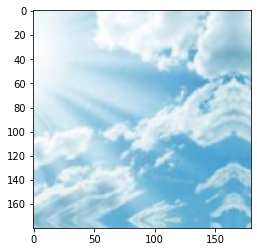

In [ ]:
for i in range(1):
  augmented_image = data_augmentation(img)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))

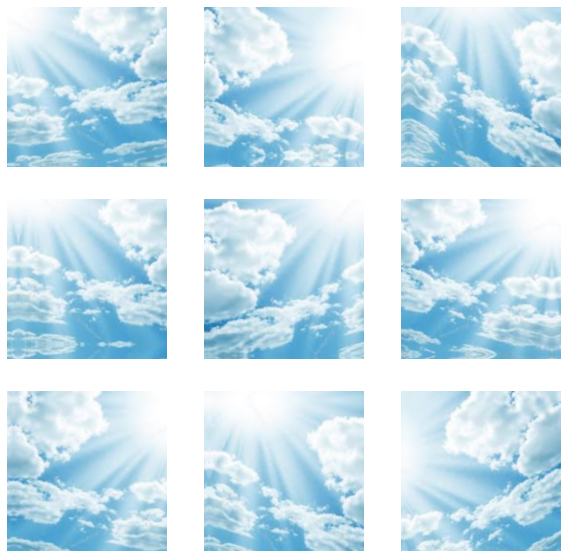

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(img)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

###INput Pipeline

In [7]:
BATCH_SIZE = 32
IMG_SIZE = 150

In [8]:
data_dir = pathlib.Path('/content/drive/MyDrive/Dphi-Analytics Club/DataThon/New/dataset')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1500


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=BATCH_SIZE)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  batch_size=BATCH_SIZE)

Found 1500 files belonging to 5 classes.
Using 300 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']


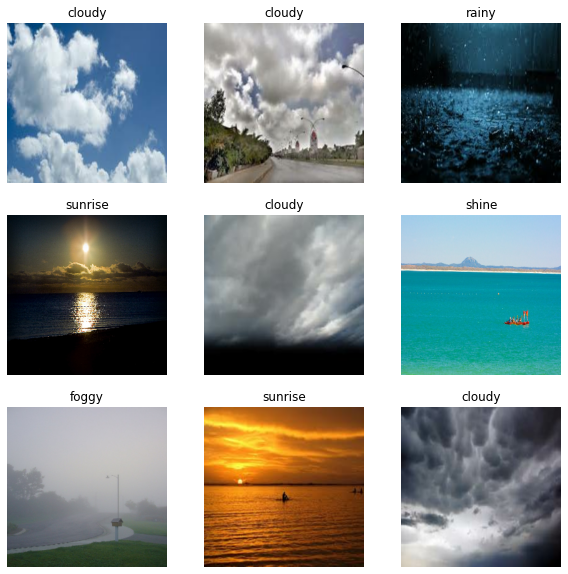

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  # tf.keras.layers.RandomContrast(factor=0.5),
  tf.keras.layers.RandomCrop(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='reflect', interpolation='bilinear')
])

###Models

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
EPOCHS_VGG = 70

####VGG19

In [30]:
checkpoint_vgg = tf.keras.callbacks.ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True, save_weights_only=True)
earlystop_vgg = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1)
callbacks_vgg = [checkpoint_vgg, earlystop_vgg]

In [18]:
vgg_19 = tf.keras.applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
vgg_19.trainable = False
vgg_19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [62]:
model = tf.keras.Sequential([
  resize_and_rescale,
  #data_augmentation,
  vgg_19,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.build(input_shape=(None, IMG_SIZE,IMG_SIZE,3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 20,026,949
Trainable params: 2,565
Non-trainable params: 20,024,384
_________________________________________________________________


In [63]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS_VGG,
  callbacks=callbacks_vgg
)

Epoch 1/70
38/38 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9400
Epoch 1: val_accuracy did not improve from 0.90000
38/38 [==============================] - 5s 119ms/step - loss: 0.2282 - accuracy: 0.9400 - val_loss: 0.3878 - val_accuracy: 0.8967
Epoch 2/70
38/38 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9408
Epoch 2: val_accuracy did not improve from 0.90000
38/38 [==============================] - 4s 119ms/step - loss: 0.2272 - accuracy: 0.9408 - val_loss: 0.3874 - val_accuracy: 0.9000
Epoch 3/70
38/38 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9408
Epoch 3: val_accuracy did not improve from 0.90000
38/38 [==============================] - 5s 120ms/step - loss: 0.2262 - accuracy: 0.9408 - val_loss: 0.3871 - val_accuracy: 0.9000
Epoch 4/70
38/38 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9408
Epoch 4: val_accuracy did not improve from 0.90000
38/38 [====================

#####Fine tuning model

In [87]:
model.load_weights('/content/vgg19.h5')

In [88]:
vgg_19.trainable = True
vgg_19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [89]:
model = tf.keras.Sequential([
  resize_and_rescale,
  #data_augmentation,
  vgg_19,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.build(input_shape=(None, IMG_SIZE,IMG_SIZE,3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 20,026,949
Trainable params: 20,026,949
Non-trainable params: 0
_________________________________________________________________


In [90]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [91]:
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
checkpoint_vgg = tf.keras.callbacks.ModelCheckpoint("vgg19_finetuning.h5",monitor="val_accuracy",verbose=1,save_best_only=True, save_weights_only=True)
earlystop_vgg = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1)
callbacks_vgg = [checkpoint_vgg, earlystop_vgg]

In [94]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS_VGG-50,
  callbacks=callbacks_vgg
)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9533
Epoch 1: val_accuracy improved from -inf to 0.92000, saving model to vgg19_finetuning.h5
38/38 [==============================] - 11s 286ms/step - loss: 0.1964 - accuracy: 0.9533 - val_loss: 0.3313 - val_accuracy: 0.9200
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9833
Epoch 2: val_accuracy improved from 0.92000 to 0.94667, saving model to vgg19_finetuning.h5
38/38 [==============================] - 11s 290ms/step - loss: 0.0556 - accuracy: 0.9833 - val_loss: 0.2061 - val_accuracy: 0.9467
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9908
Epoch 3: val_accuracy did not improve from 0.94667
38/38 [==============================] - 11s 290ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.2333 - val_accuracy: 0.9467
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9

###Predictions

In [32]:
test_image_order = pd.read_csv("/content/drive/MyDrive/Dphi-Analytics Club/DataThon/Testing_set.csv")
test_image_order.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [33]:
file_paths = [[fname, '/content/drive/MyDrive/Dphi-Analytics Club/DataThon/test/' + fname] for fname in test_image_order['filename']]

In [34]:
if len(test_image_order) == len(file_paths):
    print('Number of image names i.e. ', len(test_image_order), 'matches the number of file paths i.e. ', len(file_paths))
else:
    print('Number of image names does not match the number of filepaths')

Number of image names i.e.  450 matches the number of file paths i.e.  450


In [35]:
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/drive/MyDrive/Dphi-Analytics Club/Dat...
1,Image_2.jpg,/content/drive/MyDrive/Dphi-Analytics Club/Dat...
2,Image_3.jpg,/content/drive/MyDrive/Dphi-Analytics Club/Dat...
3,Image_4.jpg,/content/drive/MyDrive/Dphi-Analytics Club/Dat...
4,Image_5.jpg,/content/drive/MyDrive/Dphi-Analytics Club/Dat...


In [36]:
test_pixel_data = []     # initialize an empty numpy array
image_size = IMG_SIZE     # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  
  img_array = cv2.imread(test_images['filepaths'][i])   
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  test_pixel_data.append([new_img_array[...,::-1]]/255)

In [37]:
test_pixel_data = np.array(test_pixel_data)

In [38]:
test_pixel_data =  test_pixel_data.reshape(-1, image_size, image_size, 3)

In [84]:
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  prediction.append(np.argmax(value))

In [85]:
predictions = []
for x in prediction:
  predictions.append(class_names[x])

predictions[:5]

['rainy', 'foggy', 'foggy', 'rainy', 'sunrise']

In [86]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>